In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [12]:
# database_type = input('What data set wanna use: Small(0), Big(1)')
# if(int(database_type)):
#     ratings_type = 'ratings.csv'
# else:
#     ratings_type = 'ratings_small.csv'

movie_database = pd.read_csv('./notebooks/ml-latest-small/movies.csv')
# users_ratings = pd.read_csv('Data/' + ratings_type)
users_ratings = pd.read_csv('./notebooks/ml-latest-small/ratings.csv')
movie_database.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
movie_database =  movie_database.rename(columns={'id':'movieId'})

# Get the total number of users and movies
num_users = len(pd.unique(users_ratings['userId']))
num_movies = len(pd.unique(movie_database['movieId']))

print("Total number of movies: " + str(num_movies))
print("Total number of users: " + str(num_users))

Total number of movies: 9742
Total number of users: 610


In [14]:
# Sample of ratings for user with ID = 1
users_ratings[users_ratings['userId'] == 1][0:5]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [36]:
def build_feedback_matrix(users_ratings,num_movies,num_users):
    # Initiate feedback matrix with all zero ratings
    # Get all unique users ids
    feedback_matrix = np.zeros((num_users,num_movies))
    users = pd.unique(users_ratings['userId'])
    for user_id in users:
        # Get the ratings for especific user id
        ratings = users_ratings[users_ratings['userId'] == user_id]
        num_ratings = len(ratings)
        # Set the rating of all the movies that the user Id has give rating
        for j in ratings.index:
            movie_id = ratings['movieId'].loc[j]
            if movie_id <= num_movies:
                feedback_matrix[user_id-1,movie_id-1] = ratings['rating'].loc[j]

    return feedback_matrix

In [37]:
# Build an NxM feedback matrix, N= Users, M= Movies
feedback_matrix = build_feedback_matrix(users_ratings,num_movies,num_users)

In [39]:
feedback_matrix

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

<AxesSubplot:>

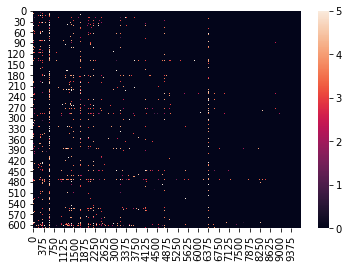

In [42]:
sns.heatmap(feedback_matrix)

In [45]:
'''
Batch gradient descent algorithm.
(Runtime currently not optimized for sparse matrices.)
Our update equations are defined as
U <- U + alpha* EV
V <- V + alpha E'U

where E = F - UV' is the residual matrix
'''

def calc_loss(E):
    return np.linalg.norm(E, ord='fro')**2

def gradient_descent(F, alpha, K=50, d=2):
    m = F.shape[0] # Number of users in feedback matrix
    n = F.shape[1] # Number of items in feedback matrix
    U = np.random.rand(m, d)
    V = np.random.rand(n, d)
    # Sanity check: we keep Frobenius norm at each step to measure our
    # loss wrt the objective function
    cost = []
    # Stop condition is currently not relative to convergence,
    # but a fixed number of iterations
    for i in np.arange(1, K):
        E = F - (U @ V.T) # Residual matrix
        iter_cost = calc_loss(E)
        cost.append(iter_cost)
        # Intermediate U and V to insure simultaneous step
        U_new = U + (alpha * (E @ V))
        V_new = V + (alpha * (E.T @ U))
        U = U_new
        V = V_new
#         print(iter_cost)
    
    return (U, V, cost)

In [76]:
U, V, cost = gradient_descent(feedback_matrix, .00005, 10000, 2)

cost

[2745394.273019594,
 1876201.4330150974,
 1465498.2682515397,
 1258871.446952991,
 1151210.2356366531,
 1093766.7798955492,
 1062457.4595482794,
 1044959.2468067496,
 1034840.9276114077,
 1028707.1904344866,
 1024752.294410184,
 1022010.5159958482,
 1019962.5256344156,
 1018327.0935561853,
 1016950.3666797627,
 1015746.8445139286,
 1014667.8521459257,
 1013684.6720086127,
 1012779.5021931144,
 1011940.598222782,
 1011159.6532845094,
 1010430.3775938473,
 1009747.7211384505,
 1009107.4424211364,
 1008505.863952041,
 1007939.729116214,
 1007406.1145743291,
 1006902.373519353,
 1006426.0964530447,
 1005975.082230235,
 1005547.315388638,
 1005140.9475445066,
 1004754.281588539,
 1004385.7579366991,
 1004033.9423774561,
 1003697.5152175237,
 1003375.2615205711,
 1003066.0622880477,
 1002768.8864654636,
 1002482.7836796697,
 1002206.8776283461,
 1001940.3600542708,
 1001682.4852458104,
 1001432.5650123466,
 1001189.9640891106,
 1000954.0959311074,
 1000724.4188600574,
 1000500.4325321339,
 1

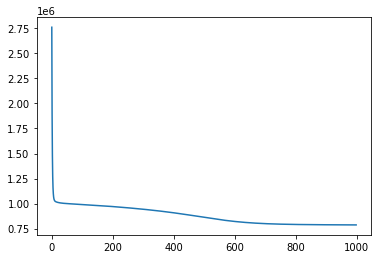

In [69]:
plt.plot(cost)

<AxesSubplot:>

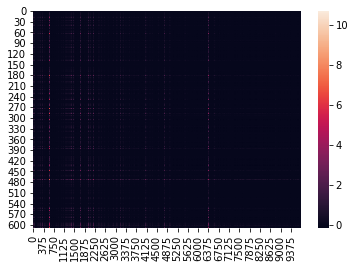

In [70]:
F_approx = U@V.T
sns.heatmap(F_approx)

In [72]:
def compare(F, F_approx, row, col):
    return_str = 'F_({i},{j}): {f}\tUV\'_({i},{j}): {fhat}\n'.format(i=row,j=col,f=F[row,col],fhat=F_approx[row,col])
    return return_str

In [75]:
for j in np.arange(0, feedback_matrix.shape[0]+1):
    print(compare(feedback_matrix, F_approx, 0, j))

F_(0,0): 4.0	UV'_(0,0): 2.597768790547776

F_(0,1): 0.0	UV'_(0,1): 1.3854225580657977

F_(0,2): 4.0	UV'_(0,2): 0.5434998666096567

F_(0,3): 0.0	UV'_(0,3): 0.045466304434066046

F_(0,4): 0.0	UV'_(0,4): 0.41537573176404197

F_(0,5): 4.0	UV'_(0,5): 1.4569842358458067

F_(0,6): 0.0	UV'_(0,6): 0.4074988402461896

F_(0,7): 0.0	UV'_(0,7): 0.07499822898953035

F_(0,8): 0.0	UV'_(0,8): 0.08954038908523698

F_(0,9): 0.0	UV'_(0,9): 1.5541121786067549

F_(0,10): 0.0	UV'_(0,10): 0.7890532380149583

F_(0,11): 0.0	UV'_(0,11): 0.13164913847187013

F_(0,12): 0.0	UV'_(0,12): 0.08838292495264212

F_(0,13): 0.0	UV'_(0,13): 0.11726367612297661

F_(0,14): 0.0	UV'_(0,14): 0.12233574861607299

F_(0,15): 0.0	UV'_(0,15): 1.247070679278102

F_(0,16): 0.0	UV'_(0,16): 0.7093939111696737

F_(0,17): 0.0	UV'_(0,17): 0.33542488061895903

F_(0,18): 0.0	UV'_(0,18): 0.922302359628205

F_(0,19): 0.0	UV'_(0,19): 0.1374944035594559

F_(0,20): 0.0	UV'_(0,20): 1.023332869190036

F_(0,21): 0.0	UV'_(0,21): 0.399305767437115

F_(